## Hidden Markov Models and Probabilistic Programming

#### *25 November 2019*
#### *DATA 1010*

In [2]:
using Pkg; Pkg.activate(".")
using Statistics, LinearAlgebra, Distributions, OffsetArrays, Random

Activating environment at `~/Data-1010-Lecture Notes/11-25-2019 - Hidden Markov Models and Prob Programming/Project.toml`


In [3]:
using Plots
gr(fontfamily = "Palatino", legend = false);

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
ERROR: LoadError: ArgumentError: Package NaNMath does not have Compat in its dependencies:
- If you have NaNMath checked out for development and have
  added Compat as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with NaNMath
Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:889
 [2] include at ./boot.jl:328 [inlined]
 [3] include_relative(::Module, ::String) at ./loading.jl:1094
 [4] include(::Module, ::String) at ./Base.jl:31
 [5] top-level scope at none:2
 [6] eval at ./boot.jl:330 [inlined]
 [7] eval(::Expr) at ./client.jl:432
 [8] top-level scope at ./none:3
in expression starting at /opt/julia/packages/NaNMath/pEdac/src/NaNMath.jl:4
ERROR: LoadError: Failed to precompile NaNMath [77ba4419-2d1f-58cd-9bb1-8ffee604a2e3] to /home/jovyan/.julia/compiled/v1.2/NaNMath/k9Y1O.ji.
Stacktrace:
 

ErrorException: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to /home/jovyan/.julia/compiled/v1.2/Plots/ld3vC.ji.

---
## EM (Frequentists' approach to evaluate parameters)

---

Today we'll continue looking at hidden Markov models. See the [notebook from last time](https://nbviewer.jupyter.org/github/data1010/problem-sets/blob/master/11-22/data1010-11-22.ipynb).

## Problem 1

Consider a hidden Markov model in which the Markov chain transition matrix takes the form 

$$
P = \left[ \begin{matrix} q & 1-q \\ 1-q & q\end{matrix} \right]
$$

Let's assume further that the conditional distribution of each random variable $X_j$ is a Gaussian with mean Let's assume that the Gaussian distribution has unknown variance $\sigma^2$. So we'll be trying to estimate $q$ and $\sigma^2$ based on a series of observations of the values of $X$.

![](1.JPG)

![](4.JPG)

![](5.JPG)

Note from above:  
- "a": expected number of stays in Markov Chain  
- "b": expected number of switches in Markov Chain
- "c": cumulative square difference between Z and X

![](6.JPG)

In [4]:
q = 0.8
σ² = 0.25
P = OffsetArray([q 1-q; 1-q q], 0:1, 0:1)

Random.seed!(1)

function markov_chain(P, n)
    Z = [0]
    for i in 1:n-1
        current_state = Z[end]
        push!(Z, rand(Bernoulli(P[current_state, 0])) ? 0 : 1)
    end
    Z
end

Z = markov_chain(P, 100)
plot(Z, size = (500, 150), ylims = (-4, 4), title = "original signal", titlefont = 10)

UndefVarError: UndefVarError: plot not defined

![](2.JPG)

In [5]:
X = Z + √(σ²)*randn(100)
plot(X, size = (500, 150), title = "corrupted signal", titlefont = 10, color = :DarkOrange, ylims = (-4, 4))

UndefVarError: UndefVarError: plot not defined

![](3.JPG)

Let's tidy things up a bit by making a new type for these hidden Markov model observations:

In [4]:
struct HMObservation
    Z::Vector
    X::Vector
end

function hidden_markov_draw(q::Real, σ²::Real)
    P = OffsetArray([q 1-q; 1-q q], 0:1, 0:1)
    Z = markov_chain(P, 100)
    X = Z + √(σ²)*randn(100)
    HMObservation(Z, X)
end

import Plots.plot
function plot(H::HMObservation)
    p = plot(H.Z, size = (500, 150), ylims = (-4, 4), label = "original signal")
    plot!(p, H.X)
    p
end

plot (generic function with 4 methods)

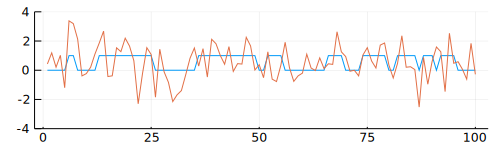

In [5]:
plot(hidden_markov_draw(0.8, 1.0))

Let's see how Expectation-Maximization works out in this context. Remember that our goal is to find good parameters of the model (which in this case we will know since we generated the data ourselves) based on the observed corrupted signal.

We begin by working out the likelihood (trigger warning: the amount of math notation is about to get downright comical. This is how it's done, and I'm not sure how feasible it is to come up with something better. Try to focus on the meaning of each component, and don't worry too much about the particular choices of how each function is written down. Consider it practice for getting what you need out of a research paper.)

$$
\begin{align*}
p(x_1, \ldots, x_n, z_1, \ldots, z_n) &=
p(z_1)\prod_{j=2}^n [q\mathbf{1}_{z_j = z_{j-1}} +
(1-q)\mathbf{1}_{z_j \neq z_{j-1}}]\prod_{j=1}^n \log\left(\frac{1}{\sqrt{2\pi \sigma^2}}
  e^{-\frac{(x_j-z_j)^2}{2\sigma^2}}\right)
\end{align*}
$$

(a) Explain where each factor in the expression above comes from.

(b) What would it mean for this function to have an exceptionally small value?




Now we take the log: 

$$
\begin{align*}
&\log(p(x_1, \ldots, x_n, z_1, \ldots, z_n)) =
\log(p(z_1)) + \sum_{j=2}^n
\log([q\mathbf{1}_{z_j = z_{j-1}} + (1-q)\mathbf{1}_{z_j \neq z_{j-1}}])
+ \sum_{j=1}^n \log\left(\frac{1}{\sqrt{2\pi \sigma^2}}
  e^{-\frac{(x_j-z_j)^2}{2\sigma^2}}\right) \\
&= \log(p(z_1)) + \log(q)\sum_{j=2}^n \mathbf{1}_{z_j = z_{j-1}} +
\log(1-q) \sum_{j=2}^n \mathbf{1}_{z_j \neq z_{j-1}} -
\frac{1}{2\sigma^2}\sum_{j=1}^n (x_j-z_j)^2 - \frac{n}{2} \log(2\pi\sigma^2).
\end{align*}
$$

And finally the expectation with respect to the conditional distribution of the $Z$ values given the observed $X$ values: 

$$
\begin{align*}
&\mathbb{E}\left[\log(p(Z_1))\right] +
\log(q)\mathbb{E}\left[\sum_{j=2}^n \mathbf{1}_{Z_j = Z_{j-1}}\right] +
\log(1-q) \mathbb{E}\left[\sum_{j=2}^n \mathbf{1}_{Z_j \neq Z_{j-1}}\right] -
\frac{1}{2\sigma^2}\mathbb{E}\left[\sum_{j=1}^n (x_j-Z_j)^2\right] -
\mathbb{E}\left[\frac{n}{2} \log(2\pi\sigma^2)\right] \\
&=
\log(p(Z_1)) +
\log(q)\underbrace{\mathbb{E}\left[\sum_{j=2}^n \mathbf{1}_{Z_j = Z_{j-1}}\right]}_{a} +
\log(1-q) \underbrace{\mathbb{E}\left[\sum_{j=2}^n \mathbf{1}_{Z_j \neq Z_{j-1}}\right]}_{b} -
\frac{1}{2\sigma^2}\underbrace{\mathbb{E}\left[\sum_{j=1}^n (x_j-Z_j)^2\right]}_{c} -
\frac{n}{2} \log(2\pi\sigma^2) \\
&=
\log(p(Z_1)) + a\log(q) + b\log(1-q) - \frac{c}{2\sigma^2} -
\frac{n}{2}\log(2\pi\sigma^2).
\end{align*}
$$

We can differentiate this expression with respect to $q$ and with respect to $\sigma^2$ to find that 

$$
\begin{align*}
q &= \frac{a}{a+b} \\
\sigma^2 &= \frac{c}{n}
\end{align*}
$$

These will be the equations we use to update the parameters at each step of the EM algorithm. The remaining challenge is to estimate $a$, $b$, and $c$.

(c) Let's focus on $a$. Interpret its value. For which of the following observed $X$ values would it be larger? What are some strategies we could use for estimating it?

<img src="corrupted1.svg">

<img src="corrupted2.svg">

Note for the graph below: Think of the conditional distribution of Z given X as a collection of samples drawn

![](7.JPG)

Note for graph below: Therefore, when we can think as sampling, the **estimated expected number of switches can be obtained by taking the mean of a big number of samples (Monte Carlo)**

![](8.JPG)

Note for graph below:   
1. dash line corresponds to proposed state
2. For the acceptance ratio, all of the other parts cancelled, we just need to take care of the state before and after

![](9.JPG)

Note for below: A concrete example. Since number of switches is not changed, the factor cancelled, therefore the acceptance ratio is less than 1.

![](10.JPG)

The first graph has only one switch (or 3 or 5), but the second graph has a big number of switch (say 50)

(d) Let's use a variation on Metropolis-Hastings where our proposal distribution suggests a change of a single random variable at a time, and furthermore we cycle through the random variables rather than choosing a random one each time. This is called **Gibbs** sampling. 

For $j$ strictly between 1 and $n$, find the conditional probability of $Z_j = 1$ given values for all of the other random variables.

(e) The script below contains a function called `gibbs_sampler` which does 75 passes through the 100 hidden random variables to draw an observation from their conditional distribution given the $X$'s. Run the code cell a few times to see how the hidden variables vary jointly in their conditional distribution given the observed signal. 

In [6]:
include("expectation-maximization.jl")

em_algorithm

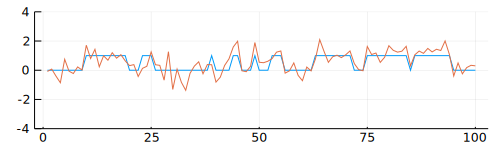

In [7]:
θ = (q, σ²)
plot(HMObservation(gibbs_sampler(X, θ), X))

(f) The script also included a function called `estimate_a_b_c` which uses 100 draws from the conditional distribution of the $Z$'s given the $X$'s to approximate $a$, $b$, and $c$. What should it be doing with the 100 values it gets for `[a,b,c]` on those 100 draws? Guess approximate values of $a$, $b$, and $c$ before running the code cell.

In [8]:
estimate_a_b_c(X, θ)

3-element Array{Float64,1}:
 82.84            
 16.16            
 26.00626943123902

(g) Finally, we can run the EM algorithm. 

In [9]:
em_algorithm(X)

k = 222, [0.8774747474747475, 0.2652003958420473]mWARNING: Some output was deleted.


---

# Probabilistic Programming (Beyasians' Approach to evaluate parameters, treat q and $\sigma$ as RV as Z)

Using MCMC to do Bayesian inference can be hard work, as we just saw. But the only thing the user really needs to specify are the priors, the structure of the model, and the sampler (e.g., in the example above, we used a Gibbs sampler with a bit-switching proposal distribution). The rest is calculation, which could in principle be handled internally. 

**Probabilistic programming** systems seek to automate Bayesian inference by allowing the user to specify model structure in the form of a *program*, choose samplers, and let the computer handle the rest. Here's an example with the data above:

![](11.JPG)

In [11]:
@model HMM(x) = begin
    n = length(x)
    z = tzeros(Int64, n)
    q ~ Uniform(0, 1)
    σ² ~ InverseGamma(1e-3, 1e-3)
    P = OffsetArray([ q  1-q
                     1-q  q ], 0:1, 0:1)
    z[1] ~ DiscreteNonParametric(0:1, [0.5, 0.5])
    x[1] ~ Normal(z[1], σ²)
    for i in 2:n
        z[i] ~ DiscreteNonParametric(0:1, collect(P[z[i-1],:]))
        x[i] ~ Normal(z[i], σ²)
    end
end

HMM (generic function with 2 methods)

Next we choose samplers. In practice, Metropolis-Hastings with a naive proposal distribution can be very inefficient because the proposal it suggests often go in directions of much smaller probability density. Hamiltonian Monte Carlo differentiates (usually autodiffs) the density $f$ and uses some fairly advanced mathematical ideas to suggest moves which are much more likely to be in directions where the density isn't way smaller:

<img src="hmc-figure.svg">

HMC is only appropriate for continuous random variables; other samplers are needed for discrete random variables like $Z_1, \ldots, Z_n$. We'll use one called **particle Gibbs**, which keeps track of several values for each random variable at the same time. (Each of these values is conceived as a particle; hence the name.) 

We can combine HMC and PG into the same model by building a Gibbs sampler which uses HMC for the continuous variables and PG for the discrete ones:

In [ ]:
# choose parameters for samplers
# 0.05 is a step size ϵ, while 10 is n_leapfrog, which we won't get into
hmc = HMC(0.05, 10, :q, :σ²)
# 20 particles
pg = PG(20, :z)
G = Gibbs(hmc, pg)

chains = sample(HMM(X), G, 10)

Note that the probabilistic programming approach taken here is not the same as the EM approach taken above. Here we are treating $q$ and $\sigma^2$ as Bayesian quantities to be estimated alongside the $Z$'s. For example, here are the values of $q$ found in the 10 runs sampled above:

In [ ]:
get_params(chains)[:q].data

--- 
## Summary

![](12.JPG)